# 1. Setup

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow opencv-python matplotlib

## 1.2 Import Dependencies

In [2]:
# Import standard dependencies
import numpy as np
import os
import cv2
import random
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [25]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [5]:
# Setup paths
P_PATH = os.path.join('data', 'pos')
N_PATH = os.path.join('data', 'neg')
A_PATH = os.path.join('data', 'anc')

In [ ]:
# Make the directories
os.makedirs(P_PATH)
os.makedirs(N_PATH)
os.makedirs(A_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [7]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        Ex_PATH = os.path.join('lfw', directory, file)
        New_PATH = os.path.join(N_PATH, file)
        os.replace(Ex_PATH, New_PATH)

## 2.2 Collect Positive and Anchor Classes

In [8]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[200:200+500,500:500+500, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imagename = os.path.join(A_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imagename, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imagename = os.path.join(P_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imagename, frame)
    
    # Show image back to screen
    cv2.imshow('Img Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()
cv2.waitKey(1)

In [ ]:
plt.imshow(frame[200:200+750,500:500+750, :])

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [36]:
anchor = tf.data.Dataset.list_files(A_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(P_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(N_PATH+'/*.jpg').take(300)

In [37]:
dir_test = anchor.as_numpy_iterator()

## 3.2 Preprocessing 

In [38]:
def preprocess(file_path):
    
    # Read 
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # resizing the image 
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    return img

## 3.3 Create Labelled Dataset

In [39]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [40]:
samples = data.as_numpy_iterator()

## 3.4 Build Train and Test Partition

In [41]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [42]:
# Dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [43]:
# Training 
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [44]:
# Testing 
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [45]:
def embed(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [46]:
embedding = embed()

## 4.2 Build Distance Layer

In [49]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method 
    def __init__(self, **kwargs):
        super().__init__()
       
    #Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [50]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [51]:
def making_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [52]:
siamese_model = making_siamese_model()

In [53]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [54]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [55]:
opt = tf.keras.optimizers.legacy.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [56]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [57]:
test_batch = train_data.as_numpy_iterator()

In [58]:
bh_1 = test_batch.next()

In [59]:
X = bh_1[:2]

In [60]:
y = bh_1[2]

In [61]:
y

array([1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

In [62]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     

        X = batch[:2]
        y = batch[2]
        
        # Forward pass
        yht = siamese_model(X, training=True)
       
        loss = binary_cross_loss(y, yht)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Training Loop

In [63]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [76]:
def train(data, Epochs):
    
    for epoch in range(1, Epochs+1):
        print('\n Epoch {}/{}'.format(epoch, Epochs))
        
        # Creating a metric object 
        p = Precision()
        r = Recall()
       
        for id, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [77]:
Epochs = 50

In [78]:
train(train_data, Epochs)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 1s 974ms/step
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 0s 16ms/step
0.3287047 0.4741784 0.98058254

 Epoch 2/50
1/1 [==============================] - 0s 231ms/step
0.3407304 0.9205608 1.0

 Epoch 3/50
1/1 [==============================] - 0s 236ms/step
0.0046246545 1.0 1.0

 Epoch 4/50
1/1 [==============================] - 0s 225ms/step
0.12425199 1.0 1.0

 Epoch 5/50
1/1 [==============================] - 0s 234ms/step
0.000113743474 0.9906103 1.0

 Epoch 6/50
1/1 [==============================] - 0s 236ms/step
0.057770774 0.9860465 0.9953052

 Epoch 7/50
1/1 [==============================] - 0s 227ms/step
0.038580995 0.9954338 1.0

 Epoch 8/50
1/1 [==============================] - 0s 238ms/step
0.00504

# 6. Evaluate Model

## 6.1 Import Metrics

In [79]:
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [80]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [81]:
y_ht = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 23ms/step


In [82]:
# Post processing the results 
[1 if pred > 0.5 else 0 for pred in y_ht ]

[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]

In [83]:
y_true

array([1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [84]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_ht)

# Return Recall Result
m.result().numpy()

1.0

In [85]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_ht)

# Return Recall Result
m.result().numpy()

1.0

In [86]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yht = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yht)
    p.update_state(y_true,yht) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 15ms/step
1.0 1.0


## 6.4 Viz Results

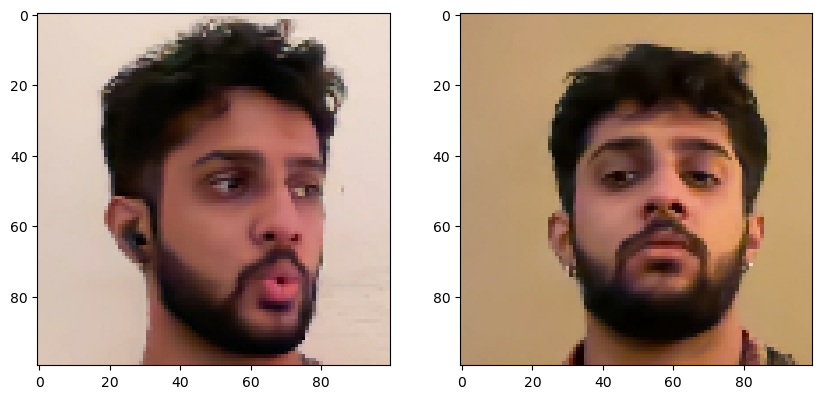

In [87]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_val[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_input[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [88]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [89]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [90]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 856ms/step


array([[1.0000000e+00],
       [2.7743736e-09],
       [1.3153270e-09],
       [1.0543579e-09]], dtype=float32)

In [91]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 8. Real Time Test

## 8.1 Verification Function

In [92]:
os.listdir(os.path.join('application_data', 'verification_images'))

['f0866e82-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'eb65a8d2-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'f053aaba-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'e020272c-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'eb982960-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'e2cf84f4-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'dcc91854-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'e50dfd4a-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'e151feb8-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'ed1628c8-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'e68be2ae-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'dcb056fc-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'ea0bc2e6-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'e1ac6f74-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'e98c4dcc-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'de3c7a0a-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'e60c6510-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'eb32a356-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'dc7ccf4e-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'ece331a2-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'e052cb00-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'ea8b626c-a0e8-11ee-8f69-ca69fb1ebd5a.jpg',
 'ded53416

In [93]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [94]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/f0866e82-a0e8-11ee-8f69-ca69fb1ebd5a.jpg
application_data/verification_images/eb65a8d2-a0e8-11ee-8f69-ca69fb1ebd5a.jpg
application_data/verification_images/f053aaba-a0e8-11ee-8f69-ca69fb1ebd5a.jpg
application_data/verification_images/e020272c-a0e8-11ee-8f69-ca69fb1ebd5a.jpg
application_data/verification_images/eb982960-a0e8-11ee-8f69-ca69fb1ebd5a.jpg
application_data/verification_images/e2cf84f4-a0e8-11ee-8f69-ca69fb1ebd5a.jpg
application_data/verification_images/dcc91854-a0e8-11ee-8f69-ca69fb1ebd5a.jpg
application_data/verification_images/e50dfd4a-a0e8-11ee-8f69-ca69fb1ebd5a.jpg
application_data/verification_images/e151feb8-a0e8-11ee-8f69-ca69fb1ebd5a.jpg
application_data/verification_images/ed1628c8-a0e8-11ee-8f69-ca69fb1ebd5a.jpg
application_data/verification_images/e68be2ae-a0e8-11ee-8f69-ca69fb1ebd5a.jpg
application_data/verification_images/dcb056fc-a0e8-11ee-8f69-ca69fb1ebd5a.jpg
application_data/verification_images/ea0bc2e6-a0e8-11ee-8f69-ca6

In [95]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [97]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[200:200+500,500:500+500, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):   
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.8, 0.6)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
# Close the image show frame
cv2.destroyAllWindows()
cv2.waitKey(1)

1/1 [==============================] - 0s 14ms/step
True
1/1 [==============================] - 0s 13ms/step
False


-1

In [17]:
np.sum(np.squeeze(results) > 0.9)

36

In [ ]:
results